# Survival RNN Regression
based on dynamics of workflow records over activeage history for requests

In [1]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm_notebook

In [81]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:99% !important; }</style>"))
pd.options.display.width = 400
pd.options.display.max_columns = 17
pd.options.display.max_rows = 9
pd.options.display.max_colwidth = 30

np.random.seed(2)

In [82]:
import torch
import torch.nn as nn
# import torch.nn.functional as F

### Import data from source

In [100]:
pd.options.display.max_rows = 9
f_feats_wf_stats_test_path = 'data/f_feats_wf_stats_test.csv'
df = pd.read_csv(f_feats_wf_stats_test_path, converters={'feats_vec_0': ast.literal_eval})
# df = df.drop('feats_vec_0',axis=1)
df = df.rename({f:f.replace('feats','feat') for f in df.columns if 'enum' in f}, axis=1)
df

,id,activeage,observed_ind,feat_enum00,feat_enum01,feats_vec_0,wf_006,wf_008,wf_009,wf_014,wf_015
0,ID00,0,1,5,92,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,0.000000,0.0
1,ID00,1,1,5,92,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,0.306944,0.0
2,ID00,2,1,5,92,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,1.306944,0.0
3,ID00,3,1,5,92,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,2.306944,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3789,ID98,12,0,6,72,"[1.0, 0.0, 1.0]",0.0,0.0,0.0,10.605556,0.0
3790,ID98,13,0,6,72,"[1.0, 0.0, 1.0]",0.0,0.0,0.0,11.605556,0.0
3791,ID98,14,0,6,72,"[1.0, 0.0, 1.0]",0.0,0.0,0.0,12.605556,0.0
3792,ID98,15,0,6,72,"[1.0, 0.0, 1.0]",0.0,0.0,0.0,13.605556,0.0


In [101]:
pd.options.display.max_rows = 29
df.tail(29)

,id,activeage,observed_ind,feat_enum00,feat_enum01,feats_vec_0,wf_006,wf_008,wf_009,wf_014,wf_015
3764,ID96,13,1,6,26,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,0.000694,0.0
3765,ID96,14,1,6,26,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,0.000694,0.0
3766,ID97,0,1,6,4,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,0.000000,0.0
3767,ID97,1,1,6,4,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,0.621528,0.0
3768,ID97,2,1,6,4,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,1.621528,0.0
3769,ID97,3,1,6,4,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,2.621528,0.0
3770,ID97,4,1,6,4,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,3.621528,0.0
3771,ID97,5,1,6,4,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,4.621528,0.0
3772,ID97,6,1,6,4,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,5.621528,0.0
3773,ID97,7,1,6,4,"[0.0, 0.0, 1.0]",0.0,0.0,0.0,6.621528,0.0


In [104]:
pd.options.display.max_rows = 9

### Data pre-processing

In [105]:
#vecs -> enum columns
col_vec_name = 'feats_vec_0'
df_feats_vec = df[col_vec_name].apply(pd.Series).astype(int)
cols_df_feats_vec = df_feats_vec.columns
df_feats_vec.columns = ['feat_enum_v%02d'%f for f in cols_df_feats_vec]

df = df.drop('feats_vec_0',axis=1)
df = pd.concat((df,df_feats_vec), axis=1)

cols_df = df.columns.values
idx_to_end = np.where(np.array(['wf' in s for s in cols_df]))[0]
cols_df_idx = np.concatenate((np.delete(np.where(cols_df),idx_to_end), idx_to_end))

cols_df = cols_df[cols_df_idx]
df = df[cols_df]
df

,id,activeage,observed_ind,feat_enum00,feat_enum01,feat_enum_v00,feat_enum_v01,feat_enum_v02,wf_006,wf_008,wf_009,wf_014,wf_015
0,ID00,0,1,5,92,0,0,1,0.0,0.0,0.0,0.000000,0.0
1,ID00,1,1,5,92,0,0,1,0.0,0.0,0.0,0.306944,0.0
2,ID00,2,1,5,92,0,0,1,0.0,0.0,0.0,1.306944,0.0
3,ID00,3,1,5,92,0,0,1,0.0,0.0,0.0,2.306944,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3789,ID98,12,0,6,72,1,0,1,0.0,0.0,0.0,10.605556,0.0
3790,ID98,13,0,6,72,1,0,1,0.0,0.0,0.0,11.605556,0.0
3791,ID98,14,0,6,72,1,0,1,0.0,0.0,0.0,12.605556,0.0
3792,ID98,15,0,6,72,1,0,1,0.0,0.0,0.0,13.605556,0.0


In [106]:
categorical_feats = [f for f in df.columns if 'enum' in f]
numerical_feats = [f for f in df.columns if 'wf' in f]
all_feats = categorical_feats + numerical_feats
target_var = 'activeage'
observed_var = 'observed_ind'
id_var = 'id'

In [107]:
vocab_size_feats_list = [max(set(df[col].values.tolist()))+1 for col in categorical_feats]
vocab_size_feats_list

[12, 101, 2, 1, 2]

### Neural network training

In [28]:
x_train = torch.tensor(df[all_feats].values)
y_train = torch.tensor(df[[target_var, observed_var]].values).float()
id_train = df[id_var].values

In [25]:
def set_init_alpha(y_train):
    tte_mean_train = np.nanmean(y_train.data.cpu().numpy()[:,0])
    mean_u = np.nanmean(y_train.data.cpu().numpy()[:,1])

    init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
    init_alpha = init_alpha/mean_u
    
    return init_alpha


"""
    Custom activation function for outputs of alpha and beta neurons
"""
def activate(x, init_alpha=1.0, max_beta_value=5.0, scalefactor=None):

    a, b = torch.unbind(x, dim=1)
    if scalefactor is not None:
        a, b = scalefactor * a, scalefactor * b

    a = init_alpha * torch.exp(a)
    if max_beta_value > 1.05:  # some value >>1.0б shift to start around 1.0, assuming input is around 0.0
        _shift = np.log(max_beta_value - 1.0)
        b -= _shift

    b = max_beta_value * torch.sigmoid(b)
    x = torch.stack([a, b],dim=1)

    return x

"""
    Loss function for Weibull parameters (discrete log-likelihood for Weibull hazard function on censored survival data):
    y_true is a (samples, 2) tensor containing time-to-event (y), and an event indicator (u)
    ab_pred is a (samples, 2) tensor containing predicted Weibull alpha (a) and beta (b) parameters
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_params_loss(y_true, ab_pred):
    y_ = y_true[:, 0]# + 1.0
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]
    
    eps = 1e-10
    hazard0 = torch.pow((y_ + eps) / a_, b_)
    hazard1 = torch.pow((y_ + 1.0) / a_, b_)
    
    res =  -1 * torch.mean(torch.log(torch.exp(hazard1 - hazard0) - (1.0 - eps)) - hazard1)
    return res


def transform_forSurvRNN(x, L):
    # x.shape: (n x m) => z.shape: (L x n x m)
    # L - is a look-back period
    n,m = x.shape
    
    y = torch.arange(n)
    z = torch.zeros(L,m,n)
    sequences_length = np.zeros(n) # sequences
    
    if x.is_cuda:
        z = z.cuda()
        
    for i in range(z.shape[2]):
        for j in range(max(0,i-L+1), i+1):
            z[j-max(0,i-L+1),: , i] = x[j, :]
        sequences_length[i] = len(range(max(0,i-L+1), i+1))
        
    z = z.permute(0,2,1)
    z = z.flip(1) # making descending by n
    sequences_length = list(sequences_length[::-1])
        
    return z, sequences_length, y

In [31]:
torch.set_printoptions(linewidth=200,edgeitems=10)
torch.manual_seed(42)

embedding_dim = 4
rnn_hidden_dim = 32
lookback_time = 50
init_alpha = set_init_alpha(y_train)

class SurvRNN(nn.Module):
    
    def __init__(self, embedding_dim, rnn_hidden_dim, lookback_time, init_alpha):
        super().__init__()
        
#         embedding_dim = 4
        self.embeddings = nn.ModuleList([nn.Embedding(num_embeddings=vocab_size_i, embedding_dim=embedding_dim) for vocab_size_i in vocab_size_feats_list])
        
        post_emb_dim = embedding_dim*len(categorical_feats) + len(numerical_feats)

#         self.rnn = nn.LSTM(input_size=post_emb_dim, hidden_size=rnn_hidden_dim)
        self.rnn = nn.GRU(input_size=post_emb_dim, hidden_size=rnn_hidden_dim)
        self.dropout = nn.Dropout()
        self.linear = nn.Linear(in_features=rnn_hidden_dim, out_features=2) # output alpha/beta of Weibull
        self.activate = activate
        
        
    def forward(self, x):
        
        n_cat_feats = len(categorical_feats)
        
        x_categorical = x[:,:n_cat_feats].long()
        x_categorical = [self.embeddings[i](x_categorical[:,i]) for i in range(n_cat_feats)]
        x_categorical = torch.cat(x_categorical, dim=1)
        
        x_numerical = x[:,n_cat_feats:].float()
        x = torch.cat((x_categorical, x_numerical), dim=1)
        
        L = lookback_time
        z, sq_len, _ = transform_forSurvRNN(x, L)
        packed_input = nn.utils.rnn.pack_padded_sequence(input=z, lengths=sq_len)
        
        packed_output, ht = self.rnn(packed_input)
#         output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        ht = ht.squeeze(0)
        ht = self.dropout(ht)
        ab = self.linear(ht)
        ab = self.activate(ab, init_alpha = init_alpha, max_beta_value = 100.0, scalefactor = 0.5)
        
        return ab

# #Test
# model = SurvRNN(embedding_dim, rnn_hidden_dim, lookback_time, init_alpha)
# model = model.cuda()
# x_batch = x_train[torch.tensor(id_train=='ID01') == True].cuda()
# ab = model(x_batch)
# ab.shape, x_batch.shape

(torch.Size([27, 2]), torch.Size([27, 7]))

In [32]:
model = SurvRNN(embedding_dim, rnn_hidden_dim, lookback_time, init_alpha)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss = weibull_params_loss

epochs = 2

loss_train_list = []

batch_generator = ((x_train[torch.tensor(id_train==id_n) == True], y_train[torch.tensor(id_train==id_n) == True]) for id_n in np.unique(id_train))

for epoch in tqdm_notebook(range(epochs+1), desc='Training'):

    model.train()
    
    x_train = x_train.cuda()
    y_train = y_train.cuda() 
    
    for x_batch, y_batch in tqdm_notebook(batch_generator, desc='batch', leave=False):
        ab_pred = model(x_batch)
        loss_train = loss(y_batch, ab_pred)
        loss_train_list.append(loss_train.data.cpu().numpy())
    
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

In [33]:
x_batch.shape, ab_pred.shape

(torch.Size([16, 7]), torch.Size([16, 2]))

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

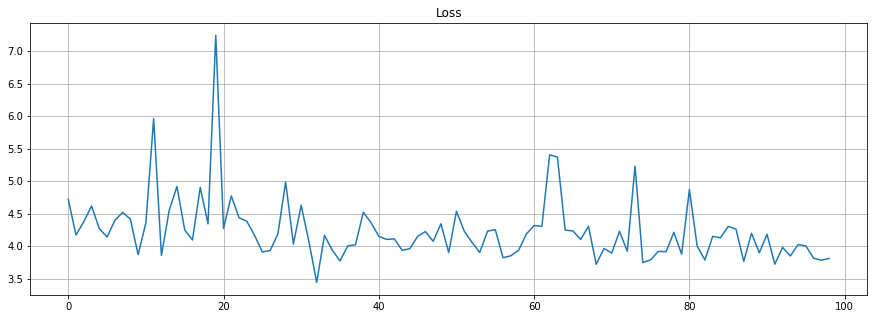

In [37]:
plt.figure(figsize=(15,5))
plt.plot(loss_train_list)
# plt.legend()
plt.title('Loss')
plt.grid(True)
plt.show()

In [41]:
idx_train_alive = np.argwhere((y_train.data.cpu().numpy()[:,0] == 0) & (y_train.data.cpu().numpy()[:,1] == 0)).ravel()
x_train_alive = x_train[idx_train_alive]
id_train_alive = id_train[idx_train_alive]
id_train_alive

array(['ID15', 'ID19', 'ID61', 'ID62', 'ID63', 'ID73', 'ID80', 'ID85',
       'ID86', 'ID88', 'ID90', 'ID94', 'ID95', 'ID98'], dtype=object)

In [43]:
y_train_alive = torch.empty(1,2).cuda()
for id_n in id_train_alive:
    y_train_alive = torch.cat((y_train_alive,y_train[torch.tensor(id_train==id_n) == True][-1].view(1,-1)))

y_train_alive = y_train_alive[1:] # remove synthetic

In [44]:
x_predict_alive = model(x_train_alive)
x_predict_alive

tensor([[39.9270,  0.8985],
        [37.8609,  0.7327],
        [38.9526,  0.7712],
        [33.5565,  0.7988],
        [38.5269,  0.9128],
        [40.5858,  0.9121],
        [35.2699,  0.7857],
        [37.0844,  0.8812],
        [42.5303,  0.9205],
        [38.1098,  0.9835],
        [41.3685,  0.8611],
        [47.1766,  0.8670],
        [44.7467,  0.9024],
        [44.7098,  0.9963]], device='cuda:0', grad_fn=<StackBackward>)

In [139]:
import math
def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

In [176]:
pd.options.display.max_rows = 9
pd.options.display.max_rows = 19
df = pd.DataFrame(np.concatenate((id_train_alive.reshape(-1,1), y_train_alive.data.cpu().numpy().astype(int)), axis=1),columns = ['id','aa','observed'])
df = pd.concat((df, pd.DataFrame(x_predict_alive.data.cpu().numpy(), columns=['alpha', 'beta'])), axis=1)
df['weibull_mean'] = df.apply(lambda x: np.round(weibull_mean(x.alpha, x.beta)).astype(int), axis=1)
df

,id,aa,observed,alpha,beta,weibull_mean
0,ID15,25,0,49.319092,1.125979,47
1,ID19,223,0,49.721340,1.110093,48
2,ID61,51,0,48.868759,1.113356,47
3,ID62,125,0,53.131382,1.091227,51
4,ID63,125,0,50.225590,1.119167,48
5,ID73,105,0,51.648796,1.113308,50
6,ID80,86,0,50.455551,1.104949,49
7,ID85,47,0,50.063709,1.134460,48
8,ID86,44,0,50.155861,1.152511,48
9,ID88,39,0,45.419819,1.177789,43
